In [1]:
import pandas as pd
from tabulate import tabulate
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import math
import numpy as np
import statistics 

list_categories_str = [ "contribution", "strengths", "weakness", "reproducibility", "detailed", "justification" ]

In [9]:

########################################################################
# Count total number of words of each review
# by summing the number of words of each category
########################################################################

print(f"Counting total number of words of each review")

# Default year is 2023
# To change to another year, please modify the variable below
year_ = "2023"

output_directory = Path(f"../miccai{year_}")
path_words_count = output_directory / 'count_words.csv'
print(f"Processing year {year_} and outputting result in {path_words_count}")



df_words = pd.read_csv(path_words_count, sep= "\t",  header=[0, 1], index_col=[0,1], skip_blank_lines=True)
for id, id_df in df_words.groupby(level=0):
    for _, title in id_df.index.values:
        for i in range (1,4):
            df_words.loc[(id,title), ("total", f"review {i}")] = 0
                    
        for category in list_categories_str :
            for i in range (1,4):
                if math.isnan(df_words.loc[(id,title), (category, f"review {i}")]):
                    df_words.loc[(id,title), (category, f"review {i}")] = 0
                df_words.loc[(id,title), ("total", f"review {i}")] += df_words.loc[(id,title), (category, f"review {i}")]
                            
df_words.sort_index(axis = 1, ascending=True, inplace=True)
df_words.to_csv(os.path.join(output_directory ,f'count_words_total.csv'), index = True, sep="\t", encoding='utf-8')
    

Counting total number of words of each review
Processing year 2023 and outputting result in ../miccai2023/count_words.csv


In [11]:
########################################################################
# Statistics regarding the number of words 
# (in total and for each category of the review separately)
########################################################################

print(f"Statistics regarding the number of words")
print(f"(in total and for each category of the review separately)")

df_stats_word_counts = pd.DataFrame(columns=["category","mean","max", "min", "median", "std", "iqr"])
df_stats_word_counts.set_index(["category"], inplace= True)

for category in list_categories_str + ["total"]:
        list_words = df_words.loc[:,(category, "review 1")].values.tolist() + df_words.loc[:,(category, "review 2")].values.tolist() + df_words.loc[:,(category, "review 3")].values.tolist()
        newlist = [x for x in list_words if math.isnan(x) == False]
        df_stats_word_counts.loc[(category), "mean"] = round(np.mean(newlist), 2)
        df_stats_word_counts.loc[(category), "median"] = np.median(newlist)
        df_stats_word_counts.loc[(category), "max"] = max(newlist)
        df_stats_word_counts.loc[(category), "min"] = min(newlist)
        df_stats_word_counts.loc[(category), "std"] = round(np.std(newlist), 2)
        df_stats_word_counts.loc[(category), "iqr"] = scipy.stats.iqr(newlist)
        deciles_ = statistics.quantiles(newlist, n=10)
        for i in range(9):
                df_stats_word_counts.loc[(category), f"deciles {i + 1}"] = deciles_[i]

print(tabulate(df_stats_word_counts, headers='keys', tablefmt='psql'))
#print(tabulate(df_stats_word_counts, headers='keys', tablefmt='latex'))

stats_directory = Path(output_directory) / "stats"
if not stats_directory.is_dir():
    os.mkdir(stats_directory)

print(f"Outputting result in {os.path.join(stats_directory ,f'stats_word_counts.csv')}")
df_stats_word_counts.to_csv(os.path.join(stats_directory ,f'stats_word_counts.csv'), index = True, sep="\t", encoding='utf-8')



Statistics regarding the number of words
(in total and for each category of the review separately)
+-----------------+--------+-------+-------+----------+--------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
| category        |   mean |   max |   min |   median |    std |   iqr |   deciles 1 |   deciles 2 |   deciles 3 |   deciles 4 |   deciles 5 |   deciles 6 |   deciles 7 |   deciles 8 |   deciles 9 |
|-----------------+--------+-------+-------+----------+--------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------|
| contribution    |  60.9  |   167 |     0 |       56 |  30.56 |  42   |        26   |          34 |          42 |          49 |          56 |          63 |        74   |        85   |       105   |
| strengths       |  60.15 |   433 |     0 |       49 |  45.96 |  46   |        19   |          27 |     

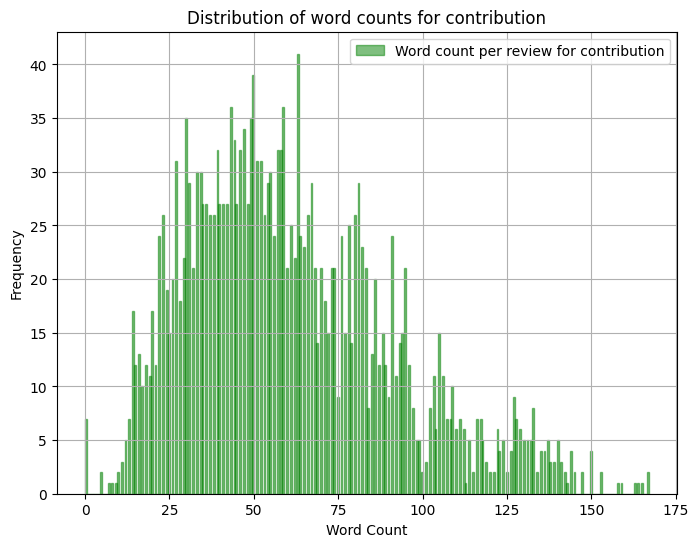

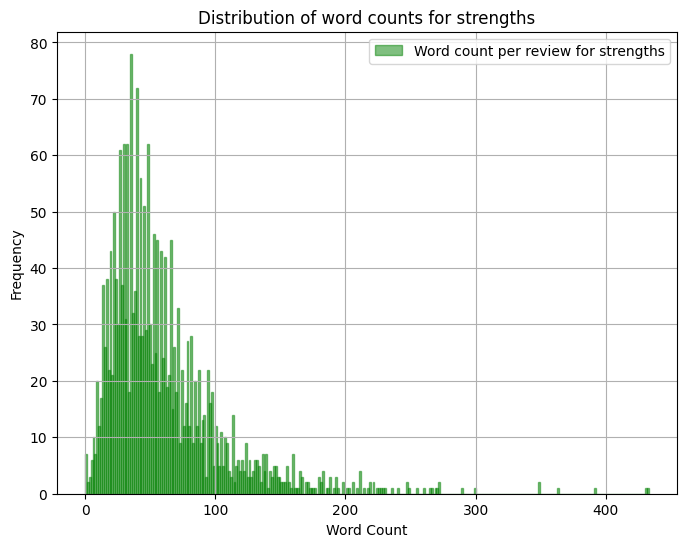

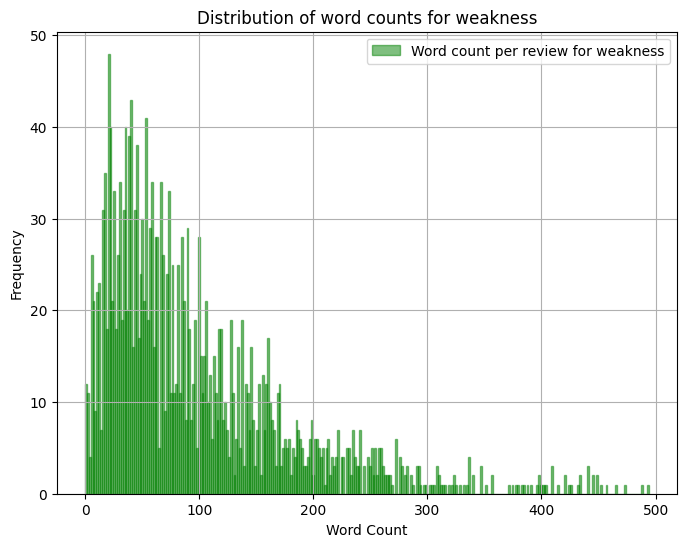

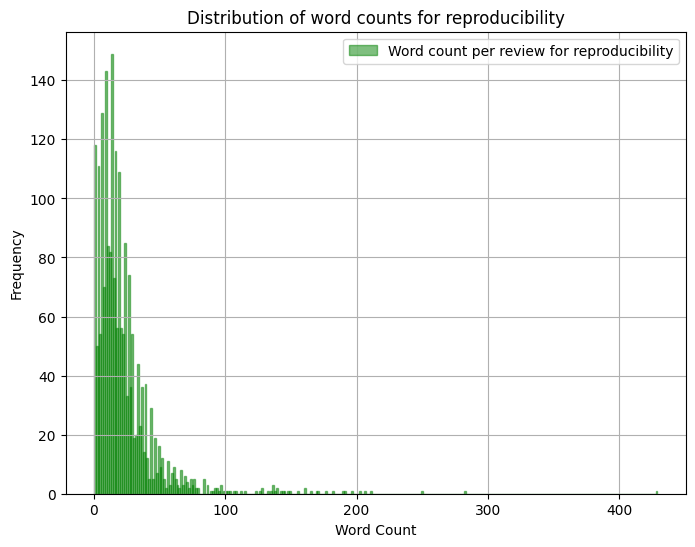

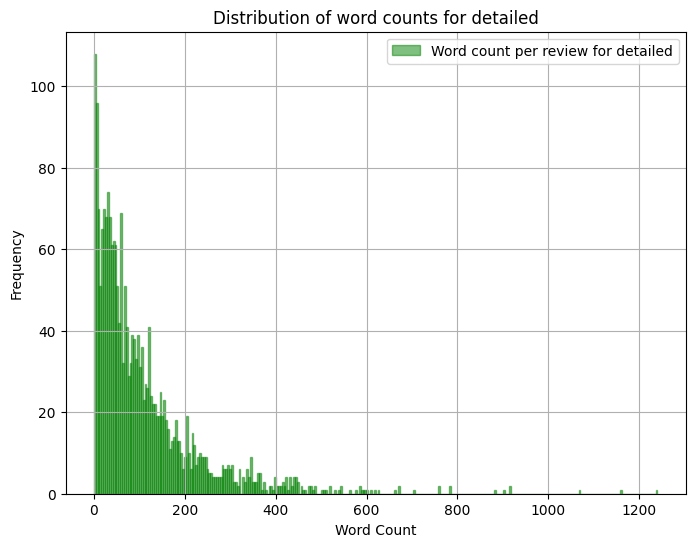

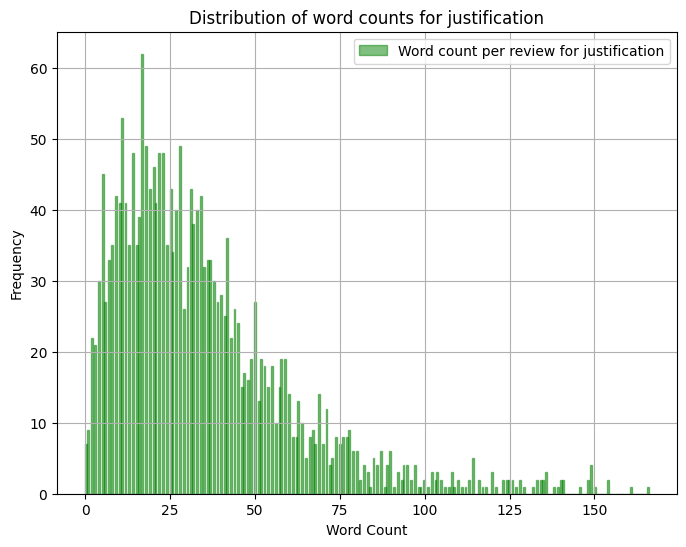

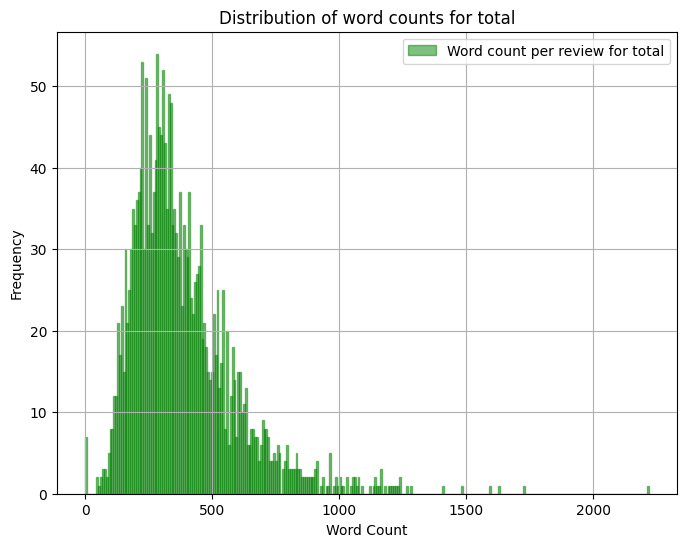

In [4]:
histo_path = Path(output_directory) / "histo"
if not histo_path.is_dir():
    os.mkdir(histo_path)

for category in list_categories_str + ["total"] :

    list = df_words.loc[:,(category, "review 1")].values.tolist() + df_words.loc[:,(category, "review 2")].values.tolist() + df_words.loc[:,(category, "review 3")].values.tolist()

    plt.figure(figsize=(8, 6))
    plt.hist(list, bins=300, alpha=0.5, edgecolor='g', color='g', label=f"Word count per review for {category}")

    plt.title(f'Distribution of word counts for {category}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(histo_path, f"{category}_hist_count_words"))

In [5]:
#output_directory = "../miccai2023/"
#path_repro_check= output_directory + "reproducibility_checklist_reviews.csv"
path_repro_check= output_directory / "reproducibility_checklist_reviews.csv"
df_check = pd.read_csv(path_words_count, sep= "\t",  header=[0, 1], index_col=[0,1], skip_blank_lines=True)



In [6]:
# Correlation between the length of the total review and the length of the reproducibility part 
repro_list = df_words.loc[:,("reproducibility", "review 1")].values.tolist() + df_words.loc[:,("reproducibility", "review 2")].values.tolist() + df_words.loc[:,("reproducibility", "review 3")].values.tolist()
total_list = df_words.loc[:,("total", "review 1")].values.tolist() + df_words.loc[:,("total", "review 2")].values.tolist() + df_words.loc[:,("total", "review 3")].values.tolist()

pearson_corr = scipy.stats.pearsonr(repro_list, total_list)
spearman_corr = scipy.stats.spearmanr(repro_list, total_list)

print(f"Correlation between the length of the total review and the length of the reproducibility part (computed on {len(repro_list)} reviews):")
print(f"Pearson's correlation: rho={round(pearson_corr.statistic,2)}, p={pearson_corr.pvalue}")
print(f"Spearmans's correlation: r={round(spearman_corr.statistic,2)}, p={spearman_corr.pvalue}")


Correlation between the length of the total review and the length of the reproducibility part (computed on 2190 reviews):
Pearson's correlation: rho=0.47, p=3.8686946577453113e-119
Spearmans's correlation: r=0.45, p=6.95538100703878e-109
